<a href="https://colab.research.google.com/github/adventurousAyan/AyanRepo/blob/master/LGBM_Ingredient_Type_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import datetime
import seaborn as sns
import gc
import os
from tqdm import tqdm 

In [ ]:
%%time

# Read data...
root = '/content/drive/MyDrive/Colab Notebooks/datasets/'

train_df = pd.read_csv(os.path.join(root, 'train_data.csv'))
weather_train_df = pd.read_csv(os.path.join(root, 'train_weather.csv'))
test_df = pd.read_csv(os.path.join(root, 'test_data.csv'))
weather_test_df = pd.read_csv(os.path.join(root, 'test_weather.csv'))
farm_meta_df = pd.read_csv(os.path.join(root, 'farm_data.csv'))
#sample_submission = pd.read_csv(os.path.join(root, 'sample_submission.csv'))

CPU times: user 19.2 s, sys: 2.33 s, total: 21.5 s
Wall time: 37.8 s


In [ ]:
train_df.columns = ['timestamp', 'farm_id', 'ingredient_type', 'yield']

In [ ]:
test_df.columns = ['timestamp', 'farm_id', 'ingredient_type', 'id']

In [ ]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['yield_log1p'] = np.log1p(train_df['yield'])


In [ ]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
#     df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [ ]:
preprocess(train_df)

In [ ]:
df_group = train_df.groupby('farm_id')['yield_log1p']
farm_mean = df_group.mean().astype(np.float16)
farm_median = df_group.median().astype(np.float16)
farm_min = df_group.min().astype(np.float16)
farm_max = df_group.max().astype(np.float16)
farm_std = df_group.std().astype(np.float16)

train_df['farm_mean'] = train_df['farm_id'].map(farm_mean)
train_df['farm_median'] = train_df['farm_id'].map(farm_median)
train_df['farm_min'] = train_df['farm_id'].map(farm_min)
train_df['farm_max'] = train_df['farm_id'].map(farm_max)
train_df['farm_std'] = train_df['farm_id'].map(farm_std)

In [ ]:
farm_mean.head()

farm_id
fid_100053    3.998047
fid_100107    6.285156
fid_100135    3.152344
fid_100249    2.826172
fid_100303    4.058594
Name: yield_log1p, dtype: float16

In [ ]:
weather_train_df.groupby('deidentified_location').apply(lambda group: group.isna().sum())

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
deidentified_location,,,,,,,,,
location 1784,0,0,24,2450,534,27,141,27,104
location 2532,0,0,1,4298,217,1,120,12,1
location 4525,0,0,0,8614,0,23,8,7883,0
location 5150,0,0,0,4399,242,3,509,6751,28
location 5290,0,0,4,3642,153,6,158,37,4
location 5410,0,0,1,3311,290,1,110,31,23
location 5489,0,0,1,2354,591,1,44,66,5
location 565,0,0,10,2992,779,10,175,0,39
location 5677,0,0,3,3830,250,3,85,1,0


In [ ]:
weather_train_df = weather_train_df.groupby('deidentified_location').apply(lambda group: group.interpolate(limit_direction='both'))

In [ ]:
weather_train_df.groupby('deidentified_location').apply(lambda group: group.isna().sum())

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed
deidentified_location,,,,,,,,,
location 1784,0,0,0,0,0,0,0,0,0
location 2532,0,0,0,0,0,0,0,0,0
location 4525,0,0,0,8614,0,0,0,0,0
location 5150,0,0,0,0,0,0,0,0,0
location 5290,0,0,0,0,0,0,0,0,0
location 5410,0,0,0,0,0,0,0,0,0
location 5489,0,0,0,0,0,0,0,0,0
location 565,0,0,0,0,0,0,0,0,0
location 5677,0,0,0,0,0,0,0,0,0


In [ ]:
farm_meta_df.drop(['operations_commencing_year','num_processing_plants'], axis=1, inplace=True)

In [ ]:
farm_meta_df.head()

,farm_id,farm_area,farming_company,deidentified_location
0,fid_110884,690.455096,Obery Farms,location 7369
1,fid_90053,252.696160,Obery Farms,location 7369
2,fid_17537,499.446528,Obery Farms,location 7369
3,fid_110392,2200.407555,Obery Farms,location 7369
4,fid_62402,10833.140121,Obery Farms,location 7369


In [ ]:
def add_lag_feature(weather_df, window=3):
    le = LabelEncoder()
    weather_df["deidentified_location"] = le.fit_transform(weather_df["deidentified_location"])
    #weather_df["farming_company"] = le.fit_transform(weather_df["farming_company"])
    #weather_df["ingredient_type"] = le.fit_transform(weather_df["ingredient_type"])
    #weather_df["farm_id"] = le.fit_transform(weather_df["farm_id"])
 
    group_df = weather_df.groupby('deidentified_location')
    cols = ['temp_obs', 'cloudiness', 'dew_temp', 'precipitation', 'pressure_sea_level', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [ ]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [ ]:
weather_train_df.head()

,timestamp,deidentified_location,temp_obs,cloudiness,wind_direction,dew_temp,pressure_sea_level,precipitation,wind_speed,temp_obs_mean_lag3,temp_obs_max_lag3,temp_obs_min_lag3,temp_obs_std_lag3,cloudiness_mean_lag3,cloudiness_max_lag3,cloudiness_min_lag3,cloudiness_std_lag3,dew_temp_mean_lag3,dew_temp_max_lag3,dew_temp_min_lag3,dew_temp_std_lag3,precipitation_mean_lag3,precipitation_max_lag3,precipitation_min_lag3,precipitation_std_lag3,pressure_sea_level_mean_lag3,pressure_sea_level_max_lag3,pressure_sea_level_min_lag3,pressure_sea_level_std_lag3,wind_direction_mean_lag3,wind_direction_max_lag3,wind_direction_min_lag3,wind_direction_std_lag3,wind_speed_mean_lag3,wind_speed_max_lag3,wind_speed_min_lag3,wind_speed_std_lag3,temp_obs_mean_lag72,temp_obs_max_lag72,temp_obs_min_lag72,temp_obs_std_lag72,cloudiness_mean_lag72,cloudiness_max_lag72,cloudiness_min_lag72,cloudiness_std_lag72,dew_temp_mean_lag72,dew_temp_max_lag72,dew_temp_min_lag72,dew_temp_std_lag72,precipitation_mean_lag72,precipitation_max_lag72,precipitation_min_lag72,precipitation_std_lag72,pressure_sea_level_mean_lag72,pressure_sea_level_max_lag72,pressure_sea_level_min_lag72,pressure_sea_level_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,2016-01-01 00:00:00,12,25.0,6.0,0.0,20.0,1019.7,-1.0,0.0,-10.601562,-10.601562,-10.601562,NaN,0.0,0.0,0.0,NaN,-13.898438,-13.898438,-13.898438,NaN,0.0,0.0,0.0,NaN,1037.0,1037.0,1037.0,NaN,0.0000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN,-10.601562,-10.601562,-10.601562,NaN,0.0,0.0,0.0,NaN,-13.898438,-13.898438,-13.898438,NaN,0.0,0.0,0.0,NaN,1037.0,1037.0,1037.0,NaN,0.0000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,2016-01-01 01:00:00,12,24.4,4.0,70.0,21.1,1020.2,-1.0,1.5,-10.851562,-10.601562,-11.101562,0.353516,0.0,0.0,0.0,0.0,-13.898438,-13.898438,-13.898438,0.000000,0.0,0.0,0.0,0.0,1037.0,1037.0,1037.0,0.141479,0.0000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,-10.851562,-10.601562,-11.101562,0.353516,0.0,0.0,0.0,0.0,-13.898438,-13.898438,-13.898438,0.000000,0.0,0.0,0.0,0.0,1037.0,1037.0,1037.0,0.141479,0.0000,0.0,0.0,0.000,0.000000,0.000000,0.0,0.000000
2,2016-01-01 02:00:00,12,22.8,2.0,0.0,21.1,1020.2,0.0,0.0,-10.570312,-10.000000,-11.101562,0.550781,0.0,0.0,0.0,0.0,-14.265625,-13.898438,-15.000000,0.635254,0.0,0.0,0.0,0.0,1037.0,1037.0,1037.0,0.115479,93.3125,280.0,0.0,161.62500,0.866699,2.599609,0.0,1.500977,-10.570312,-10.000000,-11.101562,0.550781,0.0,0.0,0.0,0.0,-14.265625,-13.898438,-15.000000,0.635254,0.0,0.0,0.0,0.0,1037.0,1037.0,1037.0,0.115479,93.3125,280.0,0.0,161.625,0.866699,2.599609,0.0,1.500977
3,2016-01-01 03:00:00,12,21.1,2.0,0.0,20.6,1020.1,0.0,0.0,-11.468750,-10.000000,-13.296875,1.680664,0.0,0.0,0.0,0.0,-14.835938,-13.898438,-15.601562,0.862305,0.0,0.0,0.0,0.0,1037.0,1038.0,1037.0,0.519531,170.0000,280.0,0.0,149.37500,1.366211,2.599609,0.0,1.304688,-11.250000,-10.000000,-13.296875,1.438477,0.0,0.0,0.0,0.0,-14.601562,-13.898438,-15.601562,0.844727,0.0,0.0,0.0,0.0,1037.0,1038.0,1037.0,0.492432,127.5000,280.0,0.0,148.625,1.025391,2.599609,0.0,1.265625
4,2016-01-01 04:00:00,12,20.0,2.0,250.0,20.0,1020.0,-1.0,2.6,-12.570312,-10.000000,-14.398438,2.289062,0.0,0.0,0.0,0.0,-15.929688,-15.000000,-17.203125,1.137695,0.0,0.0,0.0,0.0,1037.0,1038.0,1037.0,0.450928,273.2500,310.0,230.0,40.40625,2.732422,4.101562,1.5,1.304688,-11.882812,-10.000000,-14.398438,1.880859,0.0,0.0,0.0,0.0,-15.117188,-13.898438,-17.203125,1.374023,0.0,0.0,0.0,0.0,1037.0,1038.0,1037.0,0.438232,164.0000,310.0,0.0,152.375,1.639648,4.101562,0.0,1.758789


In [ ]:
weather_train_df.columns

Index(['timestamp', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'temp_obs_mean_lag3', 'temp_obs_max_lag3',
       'temp_obs_min_lag3', 'temp_obs_std_lag3', 'cloudiness_mean_lag3',
       'cloudiness_max_lag3', 'cloudiness_min_lag3', 'cloudiness_std_lag3',
       'dew_temp_mean_lag3', 'dew_temp_max_lag3', 'dew_temp_min_lag3',
       'dew_temp_std_lag3', 'precipitation_mean_lag3',
       'precipitation_max_lag3', 'precipitation_min_lag3',
       'precipitation_std_lag3', 'pressure_sea_level_mean_lag3',
       'pressure_sea_level_max_lag3', 'pressure_sea_level_min_lag3',
       'pressure_sea_level_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_speed_max_lag3', 'wind_speed_min_lag3', 'wind_speed_std_lag3',
       'temp_obs_mean_lag72', 'temp_obs_max_lag72', 'temp_ob

In [ ]:

primary_use_list = farm_meta_df['farming_company'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
farm_meta_df['farming_company'] = farm_meta_df['farming_company'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Obery Farms': 0, 'Dole Food Company': 1, 'Wayne Farms': 2, 'Sanderson Farms': 3, 'Other': 4, 'Tyson Foods': 5, 'Freight Farms': 6, 'Del Monte Foods': 7, 'Mountaire Farms': 8, 'Perdue Farms': 9, 'Southern Confederate Farms': 10, 'Foster Farms': 11, 'Kansas Ville Farms': 12, 'West Liberty Foods': 13, 'Monogram Foods': 14, 'Northland Organic Foods Corporation': 15}


123

In [ ]:
category_cols = ['farm_id', 'deidentified_location', 'farming_company']  # , 'meter'
feature_cols = ['farm_area'] + [
    'hour', 'weekend', # 'month' , 'dayofweek'
    'farm_median'] + [
    'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'temp_obs_mean_lag3', 'temp_obs_max_lag3',
       'temp_obs_min_lag3', 'temp_obs_std_lag3', 'cloudiness_mean_lag3',
       'cloudiness_max_lag3', 'cloudiness_min_lag3', 'cloudiness_std_lag3',
       'dew_temp_mean_lag3', 'dew_temp_max_lag3', 'dew_temp_min_lag3',
       'dew_temp_std_lag3', 'precipitation_mean_lag3',
       'precipitation_max_lag3', 'precipitation_min_lag3',
       'precipitation_std_lag3', 'pressure_sea_level_mean_lag3',
       'pressure_sea_level_max_lag3', 'pressure_sea_level_min_lag3',
       'pressure_sea_level_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_speed_max_lag3', 'wind_speed_min_lag3', 'wind_speed_std_lag3',
       'temp_obs_mean_lag72', 'temp_obs_max_lag72', 'temp_obs_min_lag72',
       'temp_obs_std_lag72', 'cloudiness_mean_lag72', 'cloudiness_max_lag72',
       'cloudiness_min_lag72', 'cloudiness_std_lag72', 'dew_temp_mean_lag72',
       'dew_temp_max_lag72', 'dew_temp_min_lag72', 'dew_temp_std_lag72',
       'precipitation_mean_lag72', 'precipitation_max_lag72',
       'precipitation_min_lag72', 'precipitation_std_lag72',
       'pressure_sea_level_mean_lag72', 'pressure_sea_level_max_lag72',
       'pressure_sea_level_min_lag72', 'pressure_sea_level_std_lag72',
       'wind_direction_mean_lag72', 'wind_direction_max_lag72',
       'wind_direction_min_lag72', 'wind_direction_std_lag72',
       'wind_speed_mean_lag72', 'wind_speed_max_lag72', 'wind_speed_min_lag72',
       'wind_speed_std_lag72']

In [ ]:
le = LabelEncoder()
farm_meta_df['deidentified_location'] = le.fit_transform(farm_meta_df['deidentified_location'])
farm_meta_df['farm_id'] = le.fit_transform(farm_meta_df['farm_id'])

In [ ]:
train_df['farm_id'] = le.fit_transform(train_df['farm_id'])
train_df['ingredient_type'] = le.fit_transform(train_df['ingredient_type'])

In [ ]:
train_df.head()

,timestamp,farm_id,ingredient_type,yield,date,yield_log1p,hour,weekend,month,dayofweek,farm_mean,farm_median,farm_min,farm_max,farm_std
0,2016-01-01,142,0,0.0,2016-01-01,0.0,0,4,1,4,3.355469,5.250000,0.0,6.105469,2.658203
1,2016-01-01,1307,0,0.0,2016-01-01,0.0,0,4,1,4,2.990234,4.566406,0.0,5.546875,2.302734
2,2016-01-01,376,0,0.0,2016-01-01,0.0,0,4,1,4,1.851562,2.343750,0.0,4.234375,1.553711
3,2016-01-01,134,0,0.0,2016-01-01,0.0,0,4,1,4,3.626953,5.757812,0.0,6.843750,2.882812
4,2016-01-01,986,0,0.0,2016-01-01,0.0,0,4,1,4,4.546875,7.281250,0.0,8.187500,3.576172


In [ ]:
farm_meta_df.head()

,farm_id,farm_area,farming_company,deidentified_location
0,142,690.455096,0,12
1,1307,252.696160,0,12
2,376,499.446528,0,12
3,134,2200.407555,0,12
4,986,10833.140121,0,12


In [ ]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['ingredient_type'] == target_meter]
    target_train_df = target_train_df.merge(farm_meta_df, on='farm_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['deidentified_location', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['yield_log1p'].values

    del target_train_df
    return X_train, y_train

In [ ]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [ ]:
folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
debug = False

In [ ]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 0 (12314223, 70)
cat_features [67, 68, 69]
train 9851378 valid 2462845
training LGB:


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.981021	valid_1's l2: 1.89349
[40]	training's l2: 0.649437	valid_1's l2: 1.63928
[60]	training's l2: 0.540821	valid_1's l2: 1.51035
[80]	training's l2: 0.475445	valid_1's l2: 1.46068
[100]	training's l2: 0.433185	valid_1's l2: 1.42818
[120]	training's l2: 0.403842	valid_1's l2: 1.42523
[140]	training's l2: 0.380426	valid_1's l2: 1.41929
Early stopping, best iteration is:
[127]	training's l2: 0.394524	valid_1's l2: 1.41632
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.39452359095856115}, 'valid_1': {'l2': 1.4163228057815105}})
train 9851378 valid 2462845
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.935894	valid_1's l2: 1.6937
[40]	training's l2: 0.604428	valid_1's l2: 1.48908
[60]	training's l2: 0.507711	valid_1's l2: 1.44689
[80]	training's l2: 0.454098	valid_1's l2: 1.43547
[100]	training's l2: 0.418651	valid_1's l2: 1.43259
Early stopp

NameError: ignored

In [ ]:
models0

In [ ]:
del X_train, y_train
gc.collect()

404

target_meter 1 (4256426, 70)
cat_features [67, 68, 69]
train 3405140 valid 851286
training LGB:


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.53544	valid_1's l2: 3.07748
[40]	training's l2: 1.77194	valid_1's l2: 2.09132
[60]	training's l2: 1.48639	valid_1's l2: 1.87168
[80]	training's l2: 1.33084	valid_1's l2: 1.79657
[100]	training's l2: 1.24137	valid_1's l2: 1.76772
[120]	training's l2: 1.17662	valid_1's l2: 1.75549
[140]	training's l2: 1.12707	valid_1's l2: 1.74726
[160]	training's l2: 1.08007	valid_1's l2: 1.74031
[180]	training's l2: 1.04406	valid_1's l2: 1.74183
Early stopping, best iteration is:
[164]	training's l2: 1.07262	valid_1's l2: 1.73907
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.072619438847593}, 'valid_1': {'l2': 1.7390704772340928}})
train 3405141 valid 851285
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.51744	valid_1's l2: 2.52636
[40]	training's l2: 1.72991	valid_1's l2: 1.89908
[60]	training's l2: 1.4467	valid_1's l2: 1.73139
[80]	training's l2: 1.3138

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


119

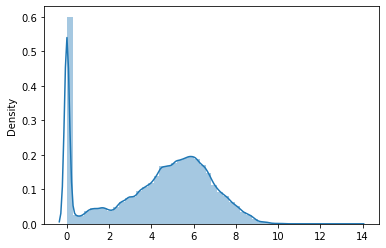

In [ ]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 2 (2741886, 70)
cat_features [67, 68, 69]
train 2193508 valid 548378
training LGB:


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.67267	valid_1's l2: 3.28666
[40]	training's l2: 1.90426	valid_1's l2: 2.65313
[60]	training's l2: 1.6766	valid_1's l2: 2.56118
[80]	training's l2: 1.55827	valid_1's l2: 2.51954
[100]	training's l2: 1.47847	valid_1's l2: 2.5092
[120]	training's l2: 1.41798	valid_1's l2: 2.51272
Early stopping, best iteration is:
[102]	training's l2: 1.472	valid_1's l2: 2.50626
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.4719990585307512}, 'valid_1': {'l2': 2.5062590967800973}})
train 2193509 valid 548377
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.62722	valid_1's l2: 2.97779
[40]	training's l2: 1.85517	valid_1's l2: 2.46047
[60]	training's l2: 1.63359	valid_1's l2: 2.37706
[80]	training's l2: 1.52403	valid_1's l2: 2.33734
[100]	training's l2: 1.44683	valid_1's l2: 2.30424
[120]	training's l2: 1.39368	valid_1's l2: 2.28545
[140]	training's l2: 1.34472	

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


130

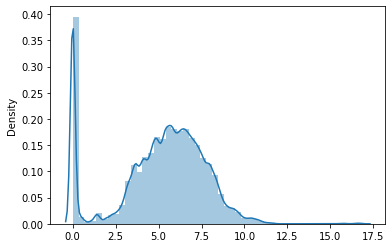

In [ ]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 3 (1290364, 70)
cat_features [67, 68, 69]
train 1032291 valid 258073
training LGB:


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 3.5648	valid_1's l2: 4.41143
[40]	training's l2: 2.53188	valid_1's l2: 3.26137
[60]	training's l2: 2.15261	valid_1's l2: 2.77803
[80]	training's l2: 1.98551	valid_1's l2: 2.55105
[100]	training's l2: 1.88763	valid_1's l2: 2.45015
[120]	training's l2: 1.82041	valid_1's l2: 2.38152
[140]	training's l2: 1.75991	valid_1's l2: 2.3524
[160]	training's l2: 1.71104	valid_1's l2: 2.33429
[180]	training's l2: 1.66327	valid_1's l2: 2.32598
[200]	training's l2: 1.62881	valid_1's l2: 2.32071
[220]	training's l2: 1.59348	valid_1's l2: 2.31949
Early stopping, best iteration is:
[219]	training's l2: 1.59525	valid_1's l2: 2.31916
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.595254295425277}, 'valid_1': {'l2': 2.319158385246595}})
train 1032291 valid 258073
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 3.53297	valid_1's l2: 3.71053
[40]	training's l2: 2.4174

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


220

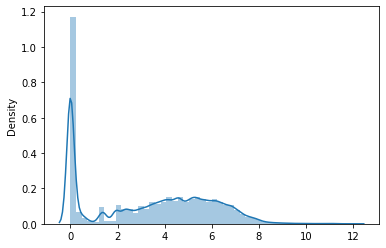

In [ ]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

In [ ]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
print('loading...')
test_df = pd.read_csv(root + '/test_data.csv')
weather_test_df = pd.read_csv(root + '/test_weather.csv')

print('preprocessing building...')
test_df.columns = ['timestamp', 'farm_id', 'ingredient_type', 'id']
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
test_df['farm_mean'] = test_df['farm_id'].map(farm_mean)
test_df['farm_median'] = test_df['farm_id'].map(farm_median)
test_df['farm_min'] = test_df['farm_id'].map(farm_min)
test_df['farm_max'] = test_df['farm_id'].map(farm_max)
test_df['farm_std'] = test_df['farm_id'].map(farm_std)

print('preprocessing weather...')
weather_test_df["deidentified_location"] = le.fit_transform(weather_test_df["deidentified_location"])
weather_test_df = weather_test_df.groupby('deidentified_location').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('deidentified_location').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage...')
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...
preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 1630.40 MB
Memory usage after optimization is: 616.43 MB
Decreased by 62.2%
Memory usage of dataframe is 24.36 MB
Memory usage after optimization is: 17.87 MB
Decreased by 26.6%


6766

In [ ]:
test_df.dtypes

timestamp          object
farm_id            object
ingredient_type    object
id                  int64
dtype: object

In [ ]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['ingredient_type'] == target_meter]
    target_test_df = target_test_df.merge(farm_meta_df, on='farm_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['deidentified_location', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [ ]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

In [ ]:
#le = LabelEncoder()
# farm_meta_df['deidentified_location'] = le.fit_transform(farm_meta_df['deidentified_location'])
# farm_meta_df['farm_id'] = le.fit_transform(farm_meta_df['farm_id'])

In [ ]:
test_df['farm_id'] = le.fit_transform(test_df['farm_id'])
test_df['ingredient_type'] = le.fit_transform(test_df['ingredient_type'])

  0%|          | 0/13 [00:00<?, ?it/s]

iterations 13
predicting 0-th model


  0%|          | 0/13 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/13 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/13 [00:00<?, ?it/s]

predicting 3-th model


  0%|          | 0/13 [00:00<?, ?it/s]

predicting 4-th model


100%|██████████| 13/13 [00:16<00:00,  1.28s/it]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


CPU times: user 15min 48s, sys: 5.63 s, total: 15min 53s
Wall time: 6min


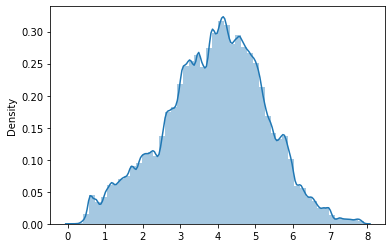

In [ ]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

  0%|          | 0/5 [00:00<?, ?it/s]

iterations 5
predicting 0-th model


  0%|          | 0/5 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/5 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/5 [00:00<?, ?it/s]

predicting 3-th model


  0%|          | 0/5 [00:00<?, ?it/s]

predicting 4-th model


100%|██████████| 5/5 [00:16<00:00,  3.33s/it]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


CPU times: user 11min 20s, sys: 2.62 s, total: 11min 23s
Wall time: 3min 34s


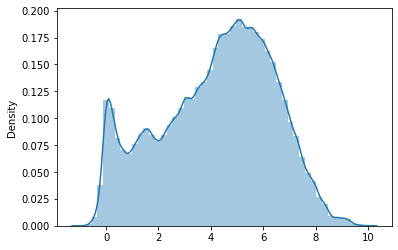

In [ ]:
%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

iterations 3
predicting 0-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 3-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 4-th model


100%|██████████| 3/3 [00:08<00:00,  2.94s/it]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


CPU times: user 4min 20s, sys: 1.38 s, total: 4min 21s
Wall time: 1min 34s


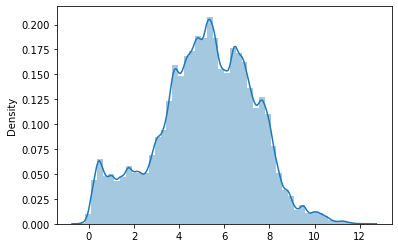

In [ ]:
%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 3-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 4-th model


100%|██████████| 2/2 [00:05<00:00,  2.81s/it]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


104

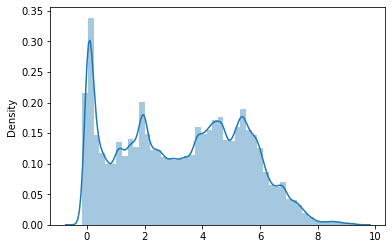

In [ ]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [ ]:
sample_submission = pd.read_csv(root + '/sample_submission.csv')

FileNotFoundError: ignored

In [ ]:
test_df.shape

(20848800, 14)

In [ ]:
sample_sub = pd.DataFrame({'id': test_df.id,'yield': 0})

In [ ]:
sample_sub.shape

(20848800, 2)

In [ ]:
sample_sub.loc[test_df['ingredient_type'] == 0, 'yield'] = np.expm1(y_test0[:12377880])
sample_sub.loc[test_df['ingredient_type'] == 1, 'yield'] = np.expm1(y_test1[:4362480])
sample_sub.loc[test_df['ingredient_type'] == 2, 'yield'] = np.expm1(y_test2[:2838240])
sample_sub.loc[test_df['ingredient_type'] == 3, 'yield'] = np.expm1(y_test3[:1270200])

In [ ]:
len(y_test0)

12640680

In [ ]:
sample_sub.loc[test_df['ingredient_type'] == 3, 'yield']

1130042     0
1130046     0
1130050     0
1130052     0
1130054     0
           ..
20848788    0
20848790    0
20848793    0
20848796    0
20848799    0
Name: yield, Length: 1270200, dtype: int64

In [ ]:
sample_sub.head()

,id,yield
0,0,12.647196
1,1,10.012668
2,2,4.229749
3,3,17.079005
4,4,35.106329


In [ ]:
sample_sub.shape

(20848800, 2)

In [ ]:
sample_sub.to_csv(root + "/sample_lgbm_ingredient_type.csv", index=False)